<a href="https://colab.research.google.com/github/gtbook/robotics/blob/master/S64_driving_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam 
import gtsam.utils.plot as gtsam_plot

from gtbook import driving
from gtbook.display import show

# SLAM

> SLAM is "Simultaneous Localization and Mapping", a key capability for mobile robots.

**This Section is still in draft mode and was released for adventurous spirits (and TAs) only.**

In [3]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(6, 4, "steampunk", 1))

## Poses in 2D and 3D

> SE(2) generalizes to SE(3).

To represent the pose of a vehicle, recall that 2D poses
$T\doteq(x,y,\theta)$ form the Special Euclidean group $SE(2)$, and
can be represented by $3\times3$ matrix of the form

$$
T=\left[\begin{array}{cc|c}
\cos\theta & -\sin\theta & x\\
sin\theta & \cos\theta & y\\
\hline 0 & 0 & 1
\end{array}\right]=\left[\begin{array}{cc}
R & t\\
0 & 1
\end{array}\right]
$$

with the $2\times1$ vector $t$
representing the position of the vehicle, and $R$ the $2\times2$
rotation matrix representing the vehicle’s orientation in the plane.

Note that this representation generalizes equally to three dimensions,
but of course $t$ will be a three-vector, and $R$ will be a $3\times3$
rotation matrix representing the 3DOF attitude of the vehicle. The
latter can be decomposed into roll, pitch, and yaw, if so desired, 
but we will not need that until the next chapter.

## Iterative Closest Points

> ICP is a seminal method to align 2 point clouds.

**Iterative closest points** or **ICP** is a method to align two point clouds, e.g., two successive LIDAR scans. Let us use superscripts $a$ and $b$ to distinguish the two point clouds, and the points therein. Under the assumption that we have a good initial estimate $\hat{T^a_b}$ for the relative pose $T^a_b$ between the two point clouds, we iterate between two steps:

- find closest point correspondences between the two clouds;
- re-estimate the relative pose $\hat{T^a_b}$ between the two clouds.

These two steps are iterated until convergence, hence the name. Below we  explain both steps in order.

### Finding Closest Points

The first step is the easiest: for each point $P^a_j$ in the first point cloud, find the closest point $P^b_j$ in the second point cloud. Stated formally we have:

$$
P^b_j = \arg \min_{P^b} \| P^b - P^a_j\|^2
$$

where minimizing the square is just as good as minimizing the distance, because they are monotonically related. This is known as the **nearest neighbor** problem, and doing so for all points is the **all nearest neighbors** problem.

The brute force algorithm of iterating over all points in the second cloud can be quite slow, and indeed finding all nearest neighbors that way has quadratic complexity. However, very fast *approximate* nearest neighbor algorithms are available. Many of these use specialized data structures, such as "KD-trees" or "Oct-trees" (in 3D). While the details are out of scope, intuitively these data structures  recursively divide up the point clouds into sub-clouds, such that sub-clouds unlikely to contain the nearest neighbor can be quickly excluded. We build this data structure ones for the second cloud, and then use it for all nearest neighbor searches, leading to complexity which is approximately $O(N \log N$).

### Estimating the Pairwise Transform

The second step is the more interesting one: given a set of closest point pairs $\{(P^a_j, P^b_j)\}$, how can we estimate from those the relative pose $\widehat{T^a_b}$ between two point clouds? This is known as the **pose alignment** problem.

Let us first assume that the two point clouds only differ by a rotation $R^a_b$. When this is the case, and assuming we have corresponding points $P^a$ and $P^b$, then each point $P^a$ in the first cloud can be expressed as a function of a point $P^b$ in the second cloud:

$$
P^a = R^a_b P^b
$$

One might be tempted to think that therefore 

$$
R^a_b = P^a (P^b)^T
$$

but that is just silly (think about why!). Interestingly, though, if we form the matrix

$$
H = \sum_j P^a_j (P^b_j)^T
$$

by summing over at least 3 point pairs $(P^a_j, P^b_j)$, it turns out that the rotation matrix $\widehat{R^a_b}$ closest to $H$ in the least squares sense *is* the best possible estimate for the unknown rotation $R^a_b$. In addition, using the *singular value decomposition* $H=U\Lambda V^T$ from linear algebra, it is *very* easy to compute:

$$
\widehat{R^a_b} = U V^T
$$

Interesting aside: this problem is known as the *orthogonal Procrustes problem* and its solution via SVD has been known since 1966, from a paper by Peter Schönemann in a *psychology* journal.

The above solves the problem when there is only rotation, but it turns out that the best possible translation estimate will always align both *centroids* of the point clouds. Hence, when there is translation present, we simply compute the matrix $H$ from the *centered* points, 

$$
H = \sum_j (P^a_j-C^a) (P^b_j-C^b)^T
$$

where the point cloud centroids $C^a$ and $C^b$ are computed as 

$$
C^a = \frac{1}{N} \sum_j P^a_j\text{    and    }C^b = \frac{1}{N} \sum_j P^b_j.
$$

Given the estimated rotation $\widehat{R^a_b}$, the translation estimate $\widehat{t^a_b}$ can then be estimated from 

$$
C^a = \widehat{R^a_b} C^b + \widehat{t^a_b},
$$

and the final relative pose estimate is given by $\widehat{T^a_b} =(\widehat{R^a_b}, \widehat{t^a_b})$. By the way, all of the above math is identical for both the 2D and 3D case.

## PoseSLAM

> PoseSLAM is SLAM with pose priors and relative pose constraints only. We can derive those from Iterative Closest Points (ICP).

**SLAM** is **Simultaneous Localization and Mapping**. 
In the SLAM problem the goal is to localize a robot using the information coming
from the robot’s sensors. 
We have already covered the localization problem in chapter 5, 
using both Markov localization and Monte Carlo localization.
The additional wrinkle in SLAM is that we do
*not* know the map a priori, and hence we have to infer the unknown map
simultaneously with the robot's location with respect to the evolving map.

**PoseSLAM** is a variant of SLAM that uses pose constraints as the
basic building block, and where we optimize over the unknown vehicles
poses. We do not explicitly optimize over a map: that is reconstructed
after the fact.

The PoseSLAM problem is:

> given a set of noisy relative measurements or **pose constraints**
> $\tilde{T}_{ij}$, recover the optimal set of poses $T_{i}^{*}$ that
> maximizes the posteriori probability, i.e., recover the MAP solution.

In the case of mapping for autonomous driving, these relative
measurements can be derived from performing ICP between overlapping
scans. We can use GPS and/or IMU measurements to decide which scans
overlap, so that we do not have to compare $O(n^{2})$ scans. Depending
on the situation, we can optimize for 3D or 2D poses, in the way we will
discus below. Afterwards, we can reconstruct a detailed map by
transforming the local LIDAR scans into the world frame, using the
optimized poses $T_{i}^{*}$.

## The PoseSLAM Factor Graph

> Factor graphs expose the sparse set of constraints tying absolute poses together.

In our factor-graph-based view of the world, a pose constraint is
represented as a factor. As before, the factor graph represent the
posterior distribution over the unknown pose variables
$\mathcal{T}=\{X_{1}\dots X_{5}\}$ given the known measurements:

$$
\phi(\mathcal{T})=\prod_{i}\phi_{i}(\mathcal{T}_{i}),
$$

where $\mathcal{T}_{i}$ is the set of poses involved with factor $\phi_i$. 
In this way, the factor graph encodes which factors are connected to which variables,
exposing the sparsity pattern of the corresponding estimation problem.

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures6/PoseSLAM-FG.png?raw=1" id="fig:PoseSLAMFG" style="width:60.0%" /><figcaption><span id="fig:PoseSLAMFG" label="fig:PoseSLAMFG">[fig:PoseSLAMFG]</span> PoseSLAM factor graph example.</figcaption>
</figure>

An example is shown in Figure
<a href="#fig:PoseSLAMFG" data-reference-type="ref" data-reference="fig:PoseSLAMFG">1</a>.
The example represents a vehicle driving around, and taking LIDAR scans
at 5 different world poses, represented by $T_{1}$ to $T_{5}$.
The factors $f_{1}$ to $f_{4}$ are binary factors representing the pose
constraints obtained by matching successive LIDAR scans using ICP. 

The factor
$f_{5}(T_{5},T_{2})$ is a so-called **loop closure** constraint:
rather than derived from two successive scans, this one is derived from
matching the scan taken at $T_{5}$ with the one at $T_{2}$.
Detecting such loops can be done through a variety of means. The final,
unary factor $f_{0}(T_{1})$ is there to “anchor” the solution to the
origin: if it is not there, the solution will be undetermined. Another
way to anchor the solution is to add unary factors at every time-step,
derived from GPS.

## MAP Inference via Least-Squares

> Linear problems with zero-mean Gaussian noise are exactly least-squares.

Finding the maximum a posteriori (MAP) solution in the case that variables are continuous and
measurements are linear combinations of them can be done via
least-squares optimization. 
Earlier in this book we have discussed MAP inference for discrete
variables, and we have discussed probability distributions for
continuous variables, but we have never put the two together.

In the case of measurements corrupted by zero-mean Gaussian noise, we can
recover the MAP solution by minimizing a sum of square differences. 
Recall that a multivariate Gaussian density **with mean** $\mu$ and **variance** $\sigma^{2}$ is
given by

$$
\mathcal{N} x\mu\sigma^2=\frac{1}{\sqrt{2\pi\sigma^{2}}}\exp\left\{ -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}\right\} .
$$

A simple 1D example can help explain this more clearly.
In particular, if we focus our attention in PoseSLAM on *just the x coordinates*, then we
predict relative measurements $\tilde{x}_{ij}$ by

$$
\tilde{x}_{ij}\approx h(x_{i,}x_{j})=x_{j}-x_{i}
$$
 and each factor in
Figure
<a href="#fig:PoseSLAMFG" data-reference-type="ref" data-reference="fig:PoseSLAMFG">1</a>
could be written as

$$
\phi(x_{i},x_{j})=\frac{1}{\sqrt{2\pi}}\exp\left\{ -\frac{1}{2}\left(x_{j}-x_{i}-\tilde{x}_{ij}\right)^{2}\right\} ,
$$

where we assumed $\sigma=1$ for now. By taking the negative log,
maximizing the posterior corresponds to minimizing the following sum of
squares, where sum ranges over all $(i,j)$ pairs for which we have a
pairwise measurement:

$$
\mathcal{X}^{*}=\arg\min_{\mathcal{X}}\sum_{k}\frac{1}{2}\left(h(x_{i},x_{j})-\tilde{x}_{ij}\right)^{2}=\arg\min_{\mathcal{X}}\sum_{k}\frac{1}{2}\left(x_{j}-x_{i}-\tilde{x}_{ij}\right)^{2}.
$$

Linear least squares problems like these are easily solved by numerical
computing packages like MATLAB or numpy.

## PoseSLAM is Nonlinear !

> Nonlinear problems need nonlinear solutions.

Unfortunately, in the PoseSLAM case we cannot use linear least squares,
because poses are not simply vectors, and the measurements are not
simply linear functions of the poses. Indeed, in PoseSLAM both the
prediction $h(T_{i},T_{j})$ and the measurement $\tilde{T}_{ij}$
are relative poses. The measurement prediction function $h(.)$ is given
by 
$$
h(T_{i},T_{j})=T_{i}^{-1}T_{j}
$$
 and the
measurement error to be minimized is

$$
\frac{1}{2}\left\Vert \log\left(\tilde{T}_{ij}^{-1}T_{i}^{-1}T_{j}\right)\right\Vert ^{2}
$$

where $\log:SE(2)\rightarrow\mathbb{R}^3$ denotes a map from $SE(2)$ to a
three-dimensional local coordinate vector $\xi$, which will be defined
in detail below.

There are two ways out of the nonlinear quandary. The first is to
realize that the only non-linearities stem from the $\sin$ and $\cos$
terms in the poses, associated with the unknown orientations
$\theta_{i}$. Hence, one solution is to try and solve for the
orientations first, and then solve for the translations using linear
least squares, exactly as above. This approach is known as **rotation
averaging** followed by linear translation recovery. Unfortunately it is
sub-optimal as it does not consider the orientation and translation
simultaneously. However, it can serve to provide a (very) good initial
estimate for nonlinear optimization, discussed below.

Indeed, we will prefer to take a second route, which is to use
**nonlinear optimization**, as discussed below.

## Nonlinear Optimization for PoseSLAM

> Linearize, solve, repeat...

As discussed, the error expressions in PoseSLAM
are *nonlinear*, and we cannot directly optimize over the poses
$T_{i}$. Instead, we will locally linearize the problem and solve
the corresponding linear problem using least-squares, and iterate this
until convergence. We do this by, at each iteration, parameterizing a
pose $T$ by 

$$
T\approx\bar{T}\Delta(\xi)
$$

where $\xi$ are local coordinates
$\xi\doteq(\delta x,\delta y,\delta\theta)$ and the incremental pose
$\Delta(\xi)\in SE(2)$ is defined as

$$
\Delta(\xi)=\left[\begin{array}{cc|c}
1 & -\delta\theta & \delta x\\
\delta\theta & 1 & \delta y\\
\hline 0 & 0 & 1
\end{array}\right]
$$

which you can recognize as a small angle
approximation of the $SE(2)$ matrix.
In 3D the local coordinates $\xi$ are 6-dimensional, and the small angle
approximation is defined as 

$$
\Delta(\xi)=\left[\begin{array}{ccc|c}
1 & -\delta\theta_{z} & \delta\theta_{y} & \delta x\\
\delta\theta_{z} & 1 & -\delta\theta_{x} & \delta y\\
-\delta\theta_{y} & \delta\theta_{x} & 1 & \delta z\\
\hline 0 & 0 & 0 & 1
\end{array}\right]
$$

With this new notation, we can approximate the
nonlinear error by a linear approximation:

$$
\frac{1}{2}\left\Vert \log\left(\tilde{T}_{ij}^{-1}T_{i}^{-1}T_{j}\right)\right\Vert ^{2}\approx\frac{1}{2}\left\Vert A_{i}\xi_{i}+A_{j}\xi_{j}-b\right\Vert ^{2}.
$$

For $SE(2)$ the matrices $A_{i}$ and $A_{j}$ are the $3\times3$ **or
Jacobian matrices** and $b$ is a $3\times1$ bias term. The above
provides a linear approximation of the term within the norm as a
function of the incremental local coordinates $\xi_{i}$ and $\xi_{j}$.
Deriving the detailed expressions for these Jacobians is beyond the
scope of this document, but suffice to say that they exist and not too
expensive to compute. In three dimensions, the Jacobian matrices are
$6\times6$ and $16\times6$, respectively.

The final optimization will—in each iteration—minimize over the local
coordinates of all poses by summing over all pose constraints. If we
index those constraints by $k$, we have the following least squares
problem:

$$
\Xi^{*}=\arg\min_{\Xi}\sum_{k}\frac{1}{2}\Vert A_{ki}\xi_{i}+A_{kj}\xi_{j}-b_{k}\Vert ^{2}
$$

where $\Xi\doteq \{  \xi_{i}\}$, the set
of all incremental pose coordinates.

After solving for the incremental updates $\Xi$, we update all poses
using the update equation above and check for convergence. 
If the error does not decrease significantly
we terminate, otherwise we linearize and solve again, until the error
converges. While this is not guaranteed to converge to a global minimum,
in practice it does so if there are enough relative measurements and a
good initial estimate is available. For example, GPS can provide us with
a good initial estimate. However, especially in urban environments GPS
can be quite noisy, and it could happen that the map quality suffers by
converging to a bad local minimum. Hence, a good quality control process
is absolutely necessary in production environments.

In summary, the algorithm for nonlinear optimization is

-   Start with an initial estimate $\mathcal{T}^{0}$

-   Iterate:

    1.  Linearize the factors
$\frac{1}{2}\Vert \log(\tilde{T}_{ij}^{-1}T_{i}^{-1}T_{j})\Vert ^{2}\approx\frac{1}{2}\Vert A_{i}\xi_{i}+A_{j}\xi_{j}-b\Vert ^{2}$

    2.  Solve the least squares problem
        $\Xi^{*}=\arg\min_{\Xi}\sum_{k}\frac{1}{2}\Vert A_{ki}\xi_{i}+A_{kj}\xi_{j}-b_{k}\Vert ^{2}$

    3.  Update $X_{i}^{t+1}\leftarrow X_{j}^{t}\Delta(\xi_{i})$

-   Until the nonlinear error
$J(\mathcal{T})\doteq\sum_{k}\frac{1}{2}\Vert \log(\tilde{T}_{ij}^{-1}T_{i}^{-1}T_{j})\Vert ^{2}$
    converges.

## Optimization with GTSAM

> GTSAM rocks PoseSLAM.

For SLAM we typically use a specialized packages such as GTSAM that 
exploit the sparsity of the factor graphs to dramatically
speed up computation. 
GTSAM exploits sparsity to be computationally efficient. Typically
measurements only provide information on the relationship between a
handful of variables, and hence the resulting factor graph will be
sparsely connected. This is exploited by the algorithms implemented in
GTSAM to reduce computational complexity. Even when graphs are too dense
to be handled efficiently by direct methods, GTSAM provides iterative
methods that are quite efficient regardless.

The following code, included in GTSAM as an example, creates the
factor graph from Figure
<a href="#fig:PoseSLAMFG" data-reference-type="ref" data-reference="fig:PoseSLAMFG">1</a>
in code:

In [4]:
graph = gtsam.NonlinearFactorGraph()
prior_model = gtsam.noiseModel.Diagonal.Sigmas((0.3, 0.3, 0.1))
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), prior_model))

# Create odometry (Between) factors between consecutive poses
odometry_model = gtsam.noiseModel.Diagonal.Sigmas((0.2, 0.2, 0.1))
Between = gtsam.BetweenFactorPose2
graph.add(Between(1, 2, gtsam.Pose2(2, 0, 0), odometry_model))
graph.add(Between(2, 3, gtsam.Pose2(2, 0, np.pi/2), odometry_model))
graph.add(Between(3, 4, gtsam.Pose2(2, 0, np.pi/2), odometry_model))
graph.add(Between(4, 5, gtsam.Pose2(2, 0, np.pi/2), odometry_model))

# Add the loop closure constraint
graph.add(Between(5, 2, gtsam.Pose2(2, 0, np.pi/2), odometry_model))

Lines 1-4 create a nonlinear factor graph and add the unary factor
$f_{0}(T_{1})$. As the vehicle travels through the world, it creates
binary factors $f_{t}(T_{t},T_{t+1})$ corresponding to odometry,
added to the graph in lines 6-12 (Note that M\_PI\_2 refers to pi/2).
But line 15 models a different event: a **loop closure**. For example,
the vehicle might recognize the same location using vision or a laser
range finder, and calculate the geometric pose constraint to when it
first visited this location. This is illustrated for poses $T_{5}$
and $T_{2}$, and generates the (red) loop closing factor
$f_{5}(T_{5},T_{2})$.


Before we can optimize, we need to create an initial estimate to start from. In GTSAM, this is done via the `gtsam.Values` type:

In [5]:
# Create the initial estimate
initial_estimate = gtsam.Values()
initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial_estimate.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial_estimate.insert(3, gtsam.Pose2(4.1, 0.1, np.pi/2))
initial_estimate.insert(4, gtsam.Pose2(4.0, 2.0, np.pi))
initial_estimate.insert(5, gtsam.Pose2(2.1, 2.1, -np.pi/2))
print(initial_estimate)

Values with 5 values:
Value 1: (gtsam::Pose2)
(0.5, 0, 0.2)

Value 2: (gtsam::Pose2)
(2.3, 0.1, -0.2)

Value 3: (gtsam::Pose2)
(4.1, 0.1, 1.5708)

Value 4: (gtsam::Pose2)
(4, 2, 3.14159)

Value 5: (gtsam::Pose2)
(2.1, 2.1, -1.5708)




We can use this initial estimate to show the factor graph below:

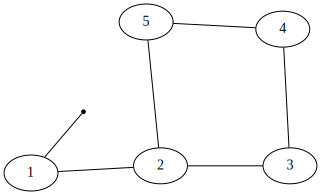

In [6]:
show(graph, initial_estimate, binary_edges=True)

Optimization is done using non-linear minimization, as explained above. In GTSAM, this is done via a `NonlinearOptimizer` class. The specific optimizer we use below is `GaussNewtonOptimizer`, which exactly implements the pseudo-code given above, but exploiting sparsity in the factor graph to do this very efficiently. The optimizer only needs a graph and an initial estimate, both of which we already created, and hence the code below is quite simple:

In [7]:
# Optimize the initial values using a Gauss-Newton nonlinear optimizer
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate)
result = optimizer.optimize()
print("Final Result:\n{}".format(result))

Final Result:
Values with 5 values:
Value 1: (gtsam::Pose2)
(2.29377e-21, -4.52805e-20, -8.15716e-21)

Value 2: (gtsam::Pose2)
(2, -8.17195e-20, -6.25199e-21)

Value 3: (gtsam::Pose2)
(4, -3.42174e-11, 1.5708)

Value 4: (gtsam::Pose2)
(4, 2, 3.14159)

Value 5: (gtsam::Pose2)
(2, 2, -1.5708)




We can also inspect the result graphically. Looking at the result as printed above only gets us so far, and more importantly: it only shows us the maximum a posteriori (MAP) solution, but not the uncertainty around it. Luckily, GTSAM can also compute the **posterior marginals**, which show the uncertainty on each recovered pose as a Gaussian density $P(T_i|Z)$, taking into account all the measurements $Z$.

In code, we do this via the `gtsam.Marginals` object, and we can plot marginals with a special function `plot_pose2`:

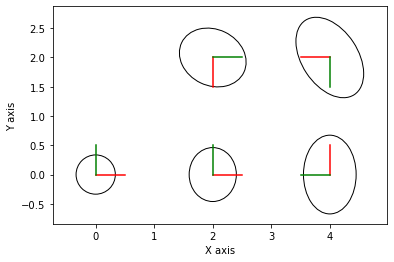

In [8]:
marginals = gtsam.Marginals(graph, result)
for i in range(1, 6):
    gtsam_plot.plot_pose2(0, result.atPose2(i), 0.5,
                          marginals.marginalCovariance(i))
plt.axis('equal'); plt.show()

The result is shown graphically in Figure
<a href="#fig:example" data-reference-type="ref" data-reference="fig:example">2</a>,
along with covariance ellipses shown in green. These covariance ellipses
in 2D indicate the marginal over position, *over all possible
orientations*, and show the area which contain 99% of the probability
mass (in 1D this would correspond to one standard deviation). The graph
shows in a clear manner that the uncertainty on pose $T_{5}$ is now
much less than if there would be only odometry measurements. The pose
with the highest uncertainty, $T_{4}$, is the one furthest away from
the unary constraint $f_{0}(T_{1})$, which is the only factor tying
the graph to a global coordinate frame.

## SLAM with Landmarks

> Take PoseSLAM, add landmarks.

So far we optimized over one type of variable, but often we build a landmark map *simultaneously* with the trajectory, i.e., this is *true* SLAM. In the next chapter, we will more thoroughly examine the full 3d case, whereas here we will model landmarks with 2D points in the plane. That does not mean that they cannot be standings for real 3-D entities in the environment: they can be the location of trees, poles, building corners, the sides of windows, the location of a stop sign in traffic, even moving pedestrians in more advanced SLAM/tracking applications.

How do we measure such landmarks? The most typical *type* of measurements are either **range** measurements, **bearing** measurements, or **bearing-range** measurements of coverage combine the former two. The details on how to obtain them are typically application-dependent, and below we will abstract away the sensor pre-processing details. For example, in the case of a LiDAR sensors, bearing range measurements can be obtained by pre-processing the every LIDAR scan, detecting prominent vertical structures for example. A real-life example that we will discuss below involves detecting and measuring the bearing/range to trees. Another often-used sensors in autonomous driving includes radar, which can often be modeled or idealized to give bearing range measurements as well.

To illustrate SLAM with landmarks, we build a small toy example with 3 bearing-range measurements to two different landmarks:

In [9]:
slam_graph = gtsam.NonlinearFactorGraph()
slam_graph.add( gtsam.PriorFactorPose2(1, gtsam.Pose2(0.0, 0.0, 0.0), prior_model))
slam_graph.add(Between(1, 2, gtsam.Pose2(2.0, 0.0, 0.0), odometry_model))
slam_graph.add(Between(2, 3, gtsam.Pose2(2.0, 0.0, 0.0), odometry_model))

In [10]:
# Add Range-Bearing measurements to two different landmarks L1 and L2
measurement_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.2]))
BR = gtsam.BearingRangeFactor2D
l = {k:gtsam.symbol('l',k) for k in [1,2]} # name landmark variables
slam_graph.add(BR(1, l[1], gtsam.Rot2.fromDegrees(45),np.sqrt(4.0 + 4.0), measurement_model)) # pose 1 -*- landmark 1
slam_graph.add(BR(2, l[1], gtsam.Rot2.fromDegrees(90), 2.0,measurement_model)) # pose 2 -*- landmark 1
slam_graph.add(BR(3, l[2], gtsam.Rot2.fromDegrees(90), 2.0,measurement_model)) # pose 3 -*- landmark 2

When we have an initial estimate, we can look at the structure of this factor graph:

In [11]:
slam_initial = gtsam.Values()
slam_initial.insert(1, gtsam.Pose2(-0.25, 0.20, 0.15))
slam_initial.insert(2, gtsam.Pose2(2.30, 0.10, -0.20))
slam_initial.insert(3, gtsam.Pose2(4.10, 0.10, 0.10))
slam_initial.insert(l[1], gtsam.Point2(1.80, 2.10))
slam_initial.insert(l[2], gtsam.Point2(4.10, 1.80))

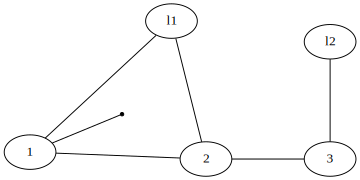

In [12]:
show(slam_graph, slam_initial, binary_edges=True)

We optimize again with LM, and show the marginals on both robot position and landmarrs, as before:

In [13]:
optimizer = gtsam.LevenbergMarquardtOptimizer(slam_graph, slam_initial)
slam_result = optimizer.optimize()

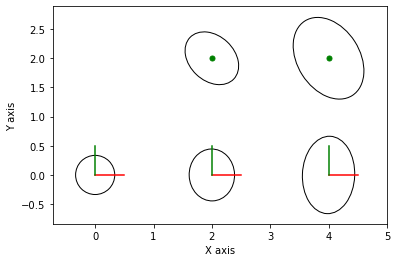

In [14]:
marginals = gtsam.Marginals(slam_graph, slam_result)
for k in [1,2,3]:
    gtsam_plot.plot_pose2(0, slam_result.atPose2(k), 0.5, marginals.marginalCovariance(k))
for j in [1,2]:
    gtsam_plot.plot_point2(0, slam_result.atPoint2(l[j]), 'g', P=marginals.marginalCovariance(l[j]))
plt.axis('equal'); plt.show()


## A Larger SLAM Example

Below we optimize a piece of the (old) [Victoria park dataset](http://www-personal.acfr.usyd.edu.au/nebot/victoria_park.htm), which involves a truck driving through a park in Sydney, extracting the position of trees in the park from LIDAR scans, just as we discussed above. The factor graph for this example is created from file and shown below:

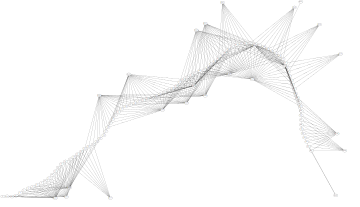

In [15]:
datafile = gtsam.findExampleDataFile('example.graph')
model = gtsam.noiseModel.Diagonal.Sigmas([0.05,0.05,2*math.pi/180])
[graph,initial] = gtsam.load2D(datafile, model)
show(graph,initial, binary_edges=True)

This is a much larger factor graph than any we have encountered before, and we can distinguish several features:

- There is a prominent backbone of truck poses, connected via odometry measurements.
- There are about 20 landmarks, some of which are seen briefly, others are seen for longer periods of time.
- The graph is very sparsely connected, and hence optimization will still be quite fast.

Optimizing with `gtsam.LevenbergMarquardtOptimizer`, again...

In [16]:
initial_poses = gtsam.utilities.extractPose2(initial)
for i in range(initial_poses.shape[0]):
    initial.update(i, initial.atPose2(i).retract(np.random.normal(scale=0.5,size=(3,))))
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial)
result = optimizer.optimize()

Below the plot both the initial estimate, which was created by adding random noise on top of the ground truth, and the optimized trajectory:

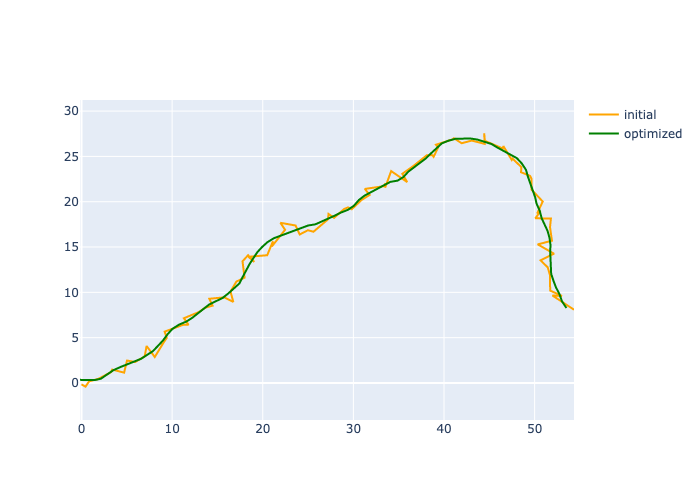

In [17]:
initial_poses = gtsam.utilities.extractPose2(initial)
fig = go.Figure()
fig.add_scatter(x=initial_poses[:,0], y=initial_poses[:,1], name="initial", marker=dict(color='orange'))
final_poses = gtsam.utilities.extractPose2(result)
fig.add_scatter(x=final_poses[:,0], y=final_poses[:,1], name="optimized", marker=dict(color='green'))
fig.update_yaxes(scaleanchor = "x",scaleratio = 1); fig.show()

## GTSAM 101

> A deeper dive in the GTSAM concepts used above.


help(gtsam.Point3)

```Point3(x=nan, y=nan, z=nan)
    Shim for the deleted Point3 type.
```
help(gtsam.Rot3.Ypr)

```Ypr(...) method of builtins.PyCapsule instance
    Ypr(y: float, p: float, r: float) -> gtsam.gtsam.Rot3
```

help(gtsam.Pose3)

```Align(...) from builtins.PyCapsule
 |      Align(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. Align(abPointPairs: std::vector<std::pair<Eigen::Matrix<double, 3, 1, 0, 3, 1>, Eigen::Matrix<double, 3, 1, 0, 3, 1> >, std::allocator<std::pair<Eigen::Matrix<double, 3, 1, 0, 3, 1>, Eigen::Matrix<double, 3, 1, 0, 3, 1> > > >) -> Optional[gtsam.gtsam.Pose3]
 |      
 |      2. Align(a: numpy.ndarray[numpy.float64[m, n]], b: numpy.ndarray[numpy.float64[m, n]]) -> Optional[gtsam.gtsam.Pose3]
 |  
 |  Expmap(...) from builtins.PyCapsule
 |      Expmap(v: numpy.ndarray[numpy.float64[m, 1]]) -> gtsam.gtsam.Pose3
 |  
 |  ExpmapDerivative(...) from builtins.PyCapsule
 |      ExpmapDerivative(xi: numpy.ndarray[numpy.float64[m, 1]]) -> numpy.ndarray[numpy.float64[6, 6]]
 |  
 |  Logmap(...) from builtins.PyCapsule
 |      Logmap(pose: gtsam.gtsam.Pose3) -> numpy.ndarray[numpy.float64[6, 1]]
 |  
 |  LogmapDerivative(...) from builtins.PyCapsule
 |      LogmapDerivative(xi: gtsam.gtsam.Pose3) -> numpy.ndarray[numpy.float64[6, 6]]
 |  
 |  adjoint(...) from builtins.PyCapsule
 |      adjoint(xi: numpy.ndarray[numpy.float64[m, 1]], y: numpy.ndarray[numpy.float64[m, 1]]) -> numpy.ndarray[numpy.float64[6, 1]]
 |  
 |  adjointMap(...) from builtins.PyCapsule
 |      adjointMap(xi: numpy.ndarray[numpy.float64[m, 1]]) -> numpy.ndarray[numpy.float64[6, 6]]
 |  
 |  adjointMap_(...) from builtins.PyCapsule
 |      adjointMap_(xi: numpy.ndarray[numpy.float64[m, 1]]) -> numpy.ndarray[numpy.float64[6, 6]]
 |  
 |  adjointTranspose(...) from builtins.PyCapsule
 |      adjointTranspose(xi: numpy.ndarray[numpy.float64[m, 1]], y: numpy.ndarray[numpy.float64[m, 1]]) -> numpy.ndarray[numpy.float64[6, 1]]
 |  
 |  adjoint_(...) from builtins.PyCapsule
 |      adjoint_(xi: numpy.ndarray[numpy.float64[m, 1]], y: numpy.ndarray[numpy.float64[m, 1]]) -> numpy.ndarray[numpy.float64[6, 1]]
 |  
 |  identity(...) from builtins.PyCapsule
 |      identity() -> gtsam.gtsam.Pose3
 |  
 |  wedge(...) from builtins.PyCapsule
 |      wedge(wx: float, wy: float, wz: float, vx: float, vy: float, vz: float) -> numpy.ndarray[numpy.float64[m, n]]
 |  
 |  ----------------------------------------------------------------------
 |  Static methods inherited from pybind11_builtins.pybind11_object:
 |  
 |  __new__(*args, **kwargs) from pybind11_builtins.pybind11_type
 |      Create and return a new object.  See help(type) for accurate signature.

```

help(driving.read_lidar_points)

help(driving.visualize_clouds)
help(driving.visualize_clouds_animation)

help(gtsam.Values.deserialize)

help(gtsam.Pose3.transformFrom)

help(gtsam.noiseModel.Diagonal)

help(gtsam.NonlinearFactorGraph())

help(gtsam.PriorFactorPose3)
help(gtsam.BetweenFactorPose3)

help(gtsam.GaussNewtonParams)

help( gtsam.GaussNewtonOptimizer)

 help(gtsam.Marginals)